## Описание проекта
Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. 

## Исходные данные

Набор данных с разметкой о токсичности правок.

- *text* - текст комментария
- *toxic* — целевой признак
___
## Содержание
* 1.Подготовка данных
 * [1.1 Загрузка данных и библиотек](#1.1-bullet)
 * [1.2 Предподготовка данных](#1.2-bullet)
 * [1.3 Подготовка данных к обучению моделей](#1.3-bullet)
* 2.Обучение моделей
 * [2.1 Обучение модели с помощью Логистической регрессии](#2.1-bullet)    
 * [2.2 Обучение модели с помощью Линейного метода опорных векторов](#2.2-bullet) 
 * [2.3 Обучение модели с помощью Случайного леса](#2.3-bullet) 
 * [2.4 Сравнение качества предсказания моделей](#2.4-bullet) 
* [3.Общие выводы](#3-bullet)


# 1. Подготовка данных

<a id='1.1-bullet'></a>
### 1.1 Загрузка данных и библиотек

In [ ]:
# Загрузим необходимые библиотеки
import pandas as pd
import pandas as pd
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import WhitespaceTokenizer 
from nltk.corpus import wordnet
from nltk.corpus import stopwords
nltk.download('averaged_perceptron_tagger')
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score
import time
import matplotlib as plt

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
# Загрузим исходные данные
comments = pd.read_csv('/datasets/toxic_comments.csv')
comments.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [ ]:
# Просмотри информацию об исходных данных
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


<a id='1.2-bullet'></a>
### 1.2 Предподготовка данных

In [ ]:
# Создадим ф-ию "clean_text" кот-ая очистить текст от лишних символов и пробелов
def clean_text(text):
    clean_text = re.sub(r'[^A-Za-z]', ' ', text)
    split_text = clean_text.lower().split()
    join_text = ' '.join(split_text)
    return join_text

In [ ]:
# Удалим лишние символы с помощью ф-ии "clean _text"
comments['lem_text'] = comments['text'].apply(clean_text)
comments.head()

,text,toxic,lem_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he matches this background colour i m se...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war it s...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...


In [ ]:
# Создадим класс для лемматизации и токенизации
tokenizer = WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()

In [ ]:
# Создадим ф-ию кот-ая определить POS-теги для каждого слова в твитах
def nltk_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN) 

In [ ]:
# Создадим ф-ию кот-ая выполнит лемматизацию и токенизацию твитов
def lemmatize(text):
    return ' '.join([lemmatizer.lemmatize(word, nltk_pos(word)) for word in tokenizer.tokenize(text)])

In [ ]:
# Применим ф-ии "nltk_pos" и "lemmatize" для обработки твитов и сохранbv обработанные тексты в новый столбец "lem_text"
comments['lem_text'] = comments['lem_text'].apply(lemmatize)

In [ ]:
# Просмотрим результат обработки 
comments.head()

,text,toxic,lem_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...


<a id='1.3-bullet'></a>
### 1.3 Подготовка данных к обучению моделей

In [ ]:
# Выделим из исходной выборки тестовую выборку
train_valid, test = train_test_split(comments, test_size=0.2, random_state=12345)  
print(train_valid.shape, test.shape)

(127656, 3) (31915, 3)


In [ ]:
# Разделим выборку train_valid на обучающую и валидационную выборки 
train, valid = train_test_split(train_valid, test_size=0.25, random_state=12345)  
print(train.shape, valid.shape)

(95742, 3) (31914, 3)


In [ ]:
# Получим набор текстов в кодировке Юникод для обучающей, валидационной и тестовой выборок
corpus_train = train['lem_text'].values.astype('U')
corpus_valid = valid['lem_text'].values.astype('U')
corpus_test = test['lem_text'].values.astype('U')

In [ ]:
# Преобразуем корпус слов в мешок слов с учетом исключения стоп-слов 
stopwords = set(stopwords.words('english'))
count_vect = CountVectorizer(analyzer='word', stop_words=stopwords)
count_vect.fit(corpus_train)
count_vect_train = count_vect.transform(corpus_train) 
count_vect_valid = count_vect.transform(corpus_valid) 
count_vect_test = count_vect.transform(corpus_test) 

# Посмотрим размер полученных в результате кодировки выборок
print(count_vect_train.shape, count_vect_valid.shape, count_vect_test.shape)

(95742, 110885) (31914, 110885) (31915, 110885)


In [ ]:
# Посмотрим количество найденных стоп-слов
len(stopwords)

179

In [ ]:
# Сохраним в отдельные переменные целевые признаки для обучающей, валидационной и тестовой выборок
target_train = train['toxic']
target_valid = valid['toxic']
target_test = test['toxic']

# Сохраним в отдельные переменные признаки для обучающей, валидационной и тестовой выборок
features_train = count_vect_train
features_valid = count_vect_valid
features_test = count_vect_test

### Вывод по п.1

Для лемматизации и токинизации твитов применена баблиотека `ntlk`, с учетом POS-тегов.
Для векторизации текста, а так же для исключения стоп-слов использована функция `CountVectorizer()`. 
Во всех твитах найдено 179 стоп-слов. 
Датасет существенно увеличился после кодирования, вместо 3 столбцов он теперь содержит 110885 столбцов. 

# 2. Обучение моделей

<a id='2.1-bullet'></a>
### 2.1 Обучение модели с помощью Логистической регрессии

In [ ]:
# Обучим модель с помощью Логистической регрессии. 
# Для определения гиперпараметров используем GridSearch
param_LR = {'C': [0.1, 1, 10]}

gs_LR = GridSearchCV(LogisticRegression(), param_LR, cv=2)
gs_LR.fit(features_valid, target_valid)
print(gs_LR.best_params_)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


{'C': 10}


In [ ]:
# Обучим модель с помощью Логистической регрессии с учетом гиперпараметра С=10
start_learn_LR = time.time()
model_LR = LogisticRegression(C=10, multi_class='auto', solver='lbfgs')
model_LR.fit(features_train, target_train)
end_learn_LR = time.time()

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [ ]:
# Получим предсказания с помощью обученной модели "model_LR" и определим метрику F1
start_predict_LR = time.time()
prediction_LR = model_LR.predict(features_test)
end_predict_LR = time.time()

In [ ]:
f1_LR = f1_score(target_test, prediction_LR)
learn_time_LR = round((end_learn_LR - start_learn_LR), 3) 
predict_time_LR = round((end_predict_LR - start_predict_LR), 3) 

print('Метрика F1', f1_LR)
print('Время обучения', learn_time_LR)
print('Время предсказания', predict_time_LR)

Метрика F1 0.7638418079096045
Время обучения 50.307
Время предсказания 0.095


<a id='2.2-bullet'></a>
### 2.2 Обучение модели с помощью Линейного метода опорных векторов

In [ ]:
# Обучим модель с помощью Линейного метода опорных векторов.
# Для определения гиперпараметров используем GridSearch
param_SVC = {'C': [0.4, 0.6, 0.8]}

gs_SVC = GridSearchCV(LinearSVC(), param_SVC, cv=2)
gs_SVC.fit(features_valid, target_valid)
print(gs_SVC.best_params_)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


{'C': 0.4}


In [ ]:
# Обучим модель с помощью Линейного метода опорных векторов с учетом гиперпараметра С=0.4
start_learn_LSVC = time.time()
model_LSVC = LinearSVC(C=0.4, random_state=12345)
model_LSVC.fit(features_train, target_train)
end_learn_LSVC = time.time()

In [ ]:
# Получим предсказания с помощью обученной модели "model_LSVC" и определим метрику F1
start_predict_LSVC = time.time()
prediction_LSVC = model_LSVC.predict(features_test)
end_predict_LSVC = time.time()

In [ ]:
f1_LSVC = f1_score(target_test, prediction_LSVC)
learn_time_LSVC = round((end_learn_LSVC - start_learn_LSVC), 3) 
predict_time_LSVC = round((end_predict_LSVC - start_predict_LSVC), 3) 

print('Метрика F1', f1_LSVC)
print('Время обучения', learn_time_LSVC)
print('Время предсказания', predict_time_LSVC)

Метрика F1 0.7632865992826866
Время обучения 8.057
Время предсказания 0.005


<a id='2.3-bullet'></a>
### 2.3 Обучение модели с помощью Случайного леса

In [ ]:
# Обучим модель с помощью Случайного леса.
# Для определения гиперпараметров используем GridSearch
param_RF = {'n_estimators': range(61, 65, 1)}

gs_RF = GridSearchCV(RandomForestClassifier(), param_RF, cv=2)
gs_RF.fit(features_valid, target_valid)
print(gs_RF.best_params_)

{'n_estimators': 64}


In [ ]:
# Обучим модель с помощью Случайного леса с учетом гиперпараметров
start_learn_RF = time.time()
model_RF = RandomForestClassifier(n_estimators=63, random_state=12345)
model_RF.fit(features_train, target_train)
end_learn_RF = time.time()

In [ ]:
# Получим предсказания с помощью обученной модели "model_RF" и определим метрику F1
start_predict_RF = time.time()
prediction_RF = model_RF.predict(features_test)
end_predict_RF = time.time()

In [ ]:
f1_RF = f1_score(target_test, prediction_RF)
learn_time_RF = round((end_learn_RF - start_learn_RF), 3) 
predict_time_RF = round((end_predict_RF - start_predict_RF), 3) 

print('Метрика F1', f1_RF)
print('Время обучения', learn_time_RF)
print('Время предсказания', predict_time_RF)

Метрика F1 0.6930022573363432
Время обучения 326.835
Время предсказания 3.72


<a id='2.4-bullet'></a>
### 2.4 Сравнение качества предсказания моделей

In [ ]:
# Соберем полученные метрики в общую таблицу для наглядности
metrics = {'LogisticRegression' :['model_LR', f1_LR, learn_time_LR, predict_time_LR],
           'LinearSVC' :['model_LSVC', f1_LSVC, learn_time_LSVC, predict_time_LSVC],
           'RandomForestClassifier': ['model_RF', f1_RF, learn_time_RF, predict_time_RF]}
result = pd.DataFrame.from_dict(metrics, orient='index', columns=['Название модели', 'Метрика F1', 'Время обучения',
                                                                 'Время предсказания'])
result

,Название модели,Метрика F1,Время обучения,Время предсказания
LogisticRegression,model_LR,0.763842,50.307,0.095
LinearSVC,model_LSVC,0.763287,8.057,0.005
RandomForestClassifier,model_RF,0.693002,326.835,3.720


Text(0.5, 0, 'Метрика F1')

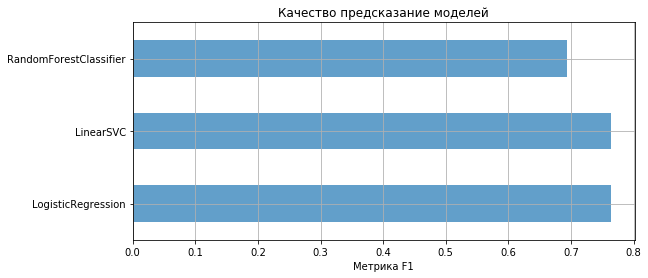

In [ ]:
result['Метрика F1'].plot(kind='barh', grid=True, alpha=0.7, figsize=(9, 4),  
                         title='Качество предсказание моделей').set_xlabel('Метрика F1')

### Вывод по п.2

Лучший результат показала **модель model_LR**, обученная с помощью Логистической регрессии. С близким результатом отработала **модель model_LSVC**, обученная с помощью Линейного метода опорных векторов. Самые низкие результаты показала **модель model_RF**, обученная с помощью Случайного леса.

Согласно условию проекта **метрика F1** должна быть не ниже **0.75**, следовательно **модели model_LR (F1=0.764) и model_LSVC (F1=0.763)** удовлетворяют условию проекта. При этом скорость обучения и предсказания **модели model_LSVC** меньше чем   **модели model_LR**. 
**Модель model_RF** не выполняет условие проекта, т.к. показывает качество предсказания ниже требуемого **F1=0.693**, кроме того время обучения и предсказания модели гораздо больше, чем у **моделей model_LR и model_LSVC**. 

<a id='3-bullet'></a>
# 3. Общие выводы

Согласно результатам исследования магазину "Викишоп", для поиска таксичных комментариев, можно порекомендовать как **модель model_LR** так и **модель model_LSVC**, т.к. обе модели показывают требуемое качество предсказания. 
Однако, если для заказчика важны такие параметры, как время обучения и времи предсказания, тогда лучше подойдет **модель model_LSVC**, т.к. среди трех рассматриваемых моделей, данная модель быстрее обучается и быстрее выполняет предсказания, и при этом качество предсказания **модели model_LR** незначительно хуже качества предсказания **модели model_LSVC**

# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [ ]  Выводы написаны